In [ ]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; padding: 0px;}
.container {width:95% !important;}
</style>

In [1]:
%matplotlib notebook
%autosave 0
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro

import ipywidgets as widgets
from functools import partial
slider_layout = widgets.Layout(width='600px', height='20px')
slider_style = {'description_width': 'initial'}
IntSlider_nice = partial(widgets.IntSlider, style=slider_style, layout=slider_layout, continuous_update=False)
FloatSlider_nice = partial(widgets.FloatSlider, style=slider_style, layout=slider_layout, continuous_update=False)
SelSlider_nice = partial(widgets.SelectionSlider, style=slider_style, layout=slider_layout, continuous_update=False)

Autosave disabled


# Probabilities

### Random/Stochastic Variable (RV)

A variable that maps the output of a random process: *throwing a coin/dice, predicting weather*
- Denoted by a capital letter: $X$

We don't know its value until we draw/sample from it: We observe the RV
- Observations are denoted with lowercase letters: $x \sim X$

We describe a RV through its domain and probability density/mass function

##### Calisthenics: Fair six-faced dice

Domain (possible outputs): $[1, 2, 3, 4, 5, 6]$ with probability mass function: $[\frac{1}{6}, \frac{1}{6}, \frac{1}{6}, \frac{1}{6}, \frac{1}{6}, \frac{1}{6}]$

- The probability of drawing a $1$ is $P(X=1) = P(1) = \frac{1}{6}$
- The probability of drawing a number greater or equal than $5$ is $P(X\geq 5) = \frac{1}{3}$
- The probability of drawing and odd number is $P(\text{odd}) = \frac{1}{2}$


### Joint, Marginal and Conditional probabilities

If we have two or more random variables we can define their joint pdf/pmf: $P(X,Y)$

From the joint we sum to obtain the marginal of $X$ or $Y$. This is the:

**Law of total probability (sum rule)**:

$$
\begin{align}
P(Y=y) &= \sum_{x \in \mathcal{X}} P(X=x, Y=y) \nonumber \\
&= \sum_{x \in \mathcal{X}} P(Y=y|X=x) P(X=x),
\end{align}
$$

where $P(Y=y|X=x)$ is the conditional probability of $y$ given $x$

$$
P(Y=y|X=x) = \frac{P(X=x, Y=y)}{P(X=x)}
$$

(iif $P(X=x) \neq 0$)

this is a special case of the 

**Chain rule of probabilities (product rule)**:

For example with four variables:
$$
\begin{align}
P(x_1, x_2, x_3, x_4) &= P(x_4|x_3, x_2, x_1) P(x_3, x_2, x_1) \nonumber \\
&= P(x_4|x_3, x_2, x_1) P(x_3| x_2, x_1) P(x_2, x_1) \nonumber \\
&= P(x_4|x_3, x_2, x_1) P(x_3| x_2, x_1) P(x_2 |x_1) P(x_1) \nonumber \\
\end{align}
$$

### Bayes Theorem

Combining the product and sum rule for two random variables we can write


$$
P(y | x) = \frac{P(x|y) P(y)}{P(x)} = \frac{P(x|y) P(y)}{\sum_{y\in\mathcal{Y}} P(x|y) P(y)}
$$

We call $P(y|x)$ the **posterior** distribution of $y$: 
> What we know of $y$ after we observe $x$ 

We call $P(y)$ the **prior** distribution of $y$
> What we know of $y$ before observing $x$


<IPython.core.display.Javascript object>


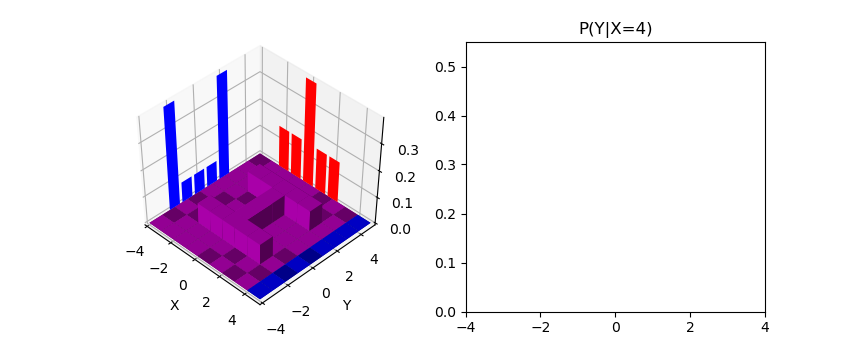

interactive(children=(IntSlider(value=4, continuous_update=False, description='x_cond', layout=Layout(height='…

In [2]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8.5, 3.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.view_init(elev=45., azim=-45)
ax2 = fig.add_subplot(1, 2, 2)
x = np.arange(-4, 5, 1); y = np.arange(-4, 5, 1)
X, Y = np.meshgrid(x, y); XY = np.zeros_like(X)
XY[-3, 2:-2] = 1; XY[2, 2:-2] = 1; XY[2:-2, 4] = 1
XY = XY/np.sum(XY)

def update_plot(x_cond):
    ax.cla()
    ax.bar(x, np.sum(XY, axis=1), zdir='x', color='b', zs=-4)
    ax.bar(y, np.sum(XY, axis=0), zdir='y', color='r', zs=5)
    colors = np.array([['m']*len(x)]*len(y))
    colors[:, x_cond-5] = 'b'
    ax.bar3d(X.ravel(), Y.ravel(), np.zeros_like(XY.ravel()), 1, 1, XY.ravel(), color=colors.ravel())
    ax.set_xlim([-4, 5]); ax.set_xlabel('X')
    ax.set_ylim([-4, 5]); ax.set_ylabel('Y')
    ax2.cla()
    ax2.bar(y, XY[X==x_cond]/(1e-8 + np.sum(XY[X==x_cond])), color='b')
    ax2.set_title("P(Y|X={0})".format(x_cond))
    ax2.set_ylim([0, 0.55])
    ax2.set_xlim([-4, 4])
    
widgets.interact(update_plot, x_cond=IntSlider_nice(min=-4, max=4, value=4));

**Independence**

If two RVs are independent then
$$
\begin{align}
P(x, y)  &= P(y|x) P(x)\nonumber \\
&= P(y) P(x)\nonumber
\end{align}
$$

> Knowing that $x$ happened does not help me to know if $y$ happened

**Conditional independence**

If two RVs are conditionally independent given a third one then
$$
P(x, y|z)  = P(x|z)P(y|z)
$$


# The meaning of probability

**Meaning 1:** We observe the outcome of a random experiment (event) several times and we count

We flip a coin 5 times and get [x, x, o, x, o]

- The probability of x is 3/5
- The probability of o is 2/5

We have estimated the probability from the **frequency** of x and o

> This is called the **Frequentist** interpretation of probability

**Meaning 2:** Probability is the **degree of belief** of an event

Probabilities describe **assumptions** and also describe **inference given those assumptions**

> This is called the **Bayesian** interpretation of probability

##### Enough philosophy, What is the difference for us?
- Intepretation of uncertainty
- Incorporation of prior information
- Model evaluation
- Handling of nuisance parameters

Specifically on inference
- Frequentist: Write the likelihood, get its maximum: **parameters are point estimates**
- Bayesian: Set priors and get posteriors: **parameters can be uncertain and have distributions too**

Most of the time both paradigms will get to the same result, but intepretation can be different!

More on [Frequentism vs Bayesianism](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)

# Inference

General definition

> Drawing conclusions from facts/evidence through reasoning and scientific premises

In our case

> Find the most certain answer  based on data and a model 

- Our scientific premises and assumptions goes into the model
- The facts are the data

### Tasks in statistical inference

- Level 1: Fit a model to the data
- Level 2: Validate and compare between models
- Level 3: Answer questions with our model: **Hypothesis testing**

### Level 1: Fitting the parameters of a model

We have a model $\mathcal{M}_j$ with parameters $\theta$

> We want to estimate $\theta~$ that best fit the data $\mathcal{D}$

We start by writing Bayes Theorem
$$
p(\theta|\mathcal{D}, \mathcal{M}_j) = \frac{p(\mathcal{D}| \theta, \mathcal{M}_j) p(\theta|\mathcal{M}_j)}{p(\mathcal{D}|\mathcal{M}_j)}
$$

Let's name these terms for the future
$$
\text{posterior} = \frac{\text{likelihood} \cdot \text{prior}}{\text{evidence}}
$$

> In the **bayesian approach** we want to find the posterior of $\theta~$

But let's start with the following

- We only care for a point estimate of $\theta~$ 
- We assume that the prior on $\theta~$ is uniform (uninformative) 

Then

$$
\begin{align}
\hat \theta &= \text{arg} \max_\theta p(\theta|\mathcal{D}, \mathcal{M}_j) \nonumber \\
&= \text{arg} \max_\theta p(\mathcal{D}| \theta, \mathcal{M}_j) \nonumber
\end{align}
$$

> This is known as the **Maximum likelihood estimator (MLE)** of $\theta~$


**Important** Likelihood is not the same as probability
- If $\theta~$ is fixed $p(\mathcal{D}| \theta, \mathcal{M}_j)$ defines a probability over $\mathcal{D}$
- If $\mathcal{D}$ is fixed $p(\mathcal{D}| \theta, \mathcal{M}_j)$ defines the likelihood of $\theta$

MLE forms the basis of the **frequentist approach** for parameter estimation
1. (Forget about Bayes theorem and) Propose a likelihood
1. Get its arg maximum

More details [here](https://github.com/magister-informatica-uach/INFO337) and course textbooks

#### Appendix: Bernoulli distribution

A distribution for binary outcomes $x\in \{0, 1\}$

The pmf is
$$
p(x|p) = \begin{cases} p & \text{if } x=1 \\ 1-p & \text{if } x=0  \end{cases}
$$

which can be written as 
$$
p(x|p) = p^x (1-p)^{1-x}
$$

In [ ]:
import scipy.stats
fig, ax = plt.subplots(figsize=(6, 3))

@widgets.interact(p=FloatSlider_nice(min=0, max=1, value=0.5, step=0.1))
def update(p):
    x = scipy.stats.bernoulli.rvs(p, size=1000)
    ax.cla()
    ax.hist(x, density=True, range=(0, 1), bins=10)

### MLE for a coin

Observations from a coin 

$$
\mathcal{D} = [x_1, x_2, \ldots, x_N]
$$

where $x_i \in \{0, 1\}$

**Assumption 1:** Observations are **independent and identically distributed (iid)**

$$
p(\mathcal{D}|\theta, \mathcal{M}_j) = \prod_{i=1}^N p(x_i|\theta, \mathcal{M}_j)
$$

**Assumption 2:** Bernoulli model with parameter $\theta \in [0, 1]$ for the observations

$$
p(x_i|\theta, \mathcal{M}_j) = \theta^{x_i} (1- \theta)^{1-x_i}
$$


> What is the MLE of $\theta~$?

**Trick of the trade:** The arg maximum of $p(x)$ is the same as $\log p(x)$

$$
\begin{align}
\hat \theta &= \text{arg} \max_\theta p(\theta|\mathcal{D}, \mathcal{M}_j) \nonumber \\
&= \text{arg} \max_\theta \log p(\theta|\mathcal{D}, \mathcal{M}_j) \nonumber \\
&= \text{arg} \max_\theta \log p(\mathcal{D}| \theta, \mathcal{M}_j) \nonumber \\
&= \text{arg} \max_\theta \sum_{i=1}^N \log p(x_i| \theta, \mathcal{M}_j) \nonumber \\
&= \text{arg} \max_\theta \sum_{i=1}^N x_i \log (\theta) + (1 -x_i) \log(1-\theta) \nonumber 
\end{align}
$$

We can take the derivate, set it to zero, and get the MLE 

$$
\hat \theta = \frac{1}{N} \sum_{i=1}^N x_i
$$


## Priors and Maximum a Posteriori

Let's lift the assumption that the prior is uniform 

- We are still looking for a point estimate of $\theta~$ 
- We keep the *iid* assumption and we consider the "log trick"

We can write

$$
\begin{align}
\hat \theta &= \text{arg} \max_\theta \log p(\theta|\mathcal{D}, \mathcal{M}_j) p(\theta|\mathcal{M}_j) \nonumber \\
&= \text{arg} \max_\theta \sum_{i=1}^N \log p(x_i| \theta, \mathcal{M}_j) + \log p(\theta|\mathcal{M}_j) \nonumber 
\end{align}
$$

> This is called the **Maximum a posteriori (MAP)** estimate of $\theta~ $

The MAP estimate corresponds to the mode of $p(\theta|\mathcal{D}, \mathcal{M}_j)$

#### In addition to the model (likelihood) we have to set the prior $p(\theta)$

This can be a [sensible choice](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations)

#### Appendix: Beta distribution

A distribution for $x \in [0, 1]$, *e.g* probabilities

The pdf is 

$$
\text{Beta}(x|\alpha, \beta) = \frac{x^{\alpha-1} (1-x)^{\beta-1}}{B(\alpha, \beta)}
$$

where $B(x,y) = \frac{\Gamma(\alpha) \Gamma(\beta)}{\Gamma(\alpha+\beta)}$ and $\Gamma(x)$ is the [Gamma function](https://en.wikipedia.org/wiki/Gamma_function)

For $\alpha=\beta=1$ we get the Uniform distribution in $[0, 1]$

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3))

@widgets.interact(alpha=FloatSlider_nice(min=0.001, max=10, value=1, step=0.1), 
                  beta=FloatSlider_nice(min=0.001, max=10, value=1, step=0.1))
def update(alpha, beta):
    x = scipy.stats.beta.rvs(alpha, beta, size=1000)
    ax.cla()
    ax.hist(x, density=True, range=(0, 1), bins=10)

#### Map for the coin


We will use a Beta prior for $\theta ~$

$$
p(\theta|\mathcal{M}_j) = \text{Beta}(\theta| \alpha, \beta) = \frac{\theta^{\alpha-1} (1-\theta)^{\beta-1}}{B(\alpha, \beta)}
$$

Omitting the terms that do not depend on $\theta~$ we get the MAP 
$$
\hat \theta= \text{arg} \max_\theta \sum_{i=1}^N x_i \log (\theta) + (1 -x_i) \log(1-\theta) +(\alpha -1) \log(\theta) + ( \beta -1) \log(1-\theta) 
$$

By setting the derivate to zero we obtain

$$
\hat \theta = \frac{1}{N+\alpha - \beta} (\alpha -1 + \sum_{i=1}^N x_i)
$$

Note that it reduces to the MLE for $\alpha=\beta=1$ (uniform)


> If we know something about the coin before observing the data we add it through $\alpha$ and $\beta$

## Bayesian inference

With MLE we get point estimates

> How good are these estimates? Can we trust them? What is their uncertainty?

Following a frequentist approach we answer this through confidence intervals/bootstrap

In a "full" bayesian approach we select likelihood/prior and aim for the posterior of $\theta~$,

$$
p(\theta|\mathcal{D}, \mathcal{M}_j) = \frac{p(\mathcal{D}| \theta, \mathcal{M}_j) p(\theta|\mathcal{M}_j)}{p(\mathcal{D}|\mathcal{M}_j)}
$$

> If we have the posterior we know everything about $\theta~$

But, how do we get the posterior?

### Analytical posterior

In some "very special cases" the posterior is analytically tractable

Enter the [**conjugate priors**](https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions)

#### Posterior for the coin


The likelihood of the coin (Bernoulli) is

$$
\begin{align}
p(\mathcal{D}|\theta, \mathcal{M}_j) &= \prod_{i=1}^N p(x_i|\theta, \mathcal{M}_j) \nonumber \\
&= \prod_{i=1}^N \theta^{x_i} (1-\theta)^{1-x_i} \nonumber \\
&= \theta^{\sum_i x_i}(1-\theta)^{N-\sum_i x_i} \nonumber 
\end{align}
$$

The prior is Beta

$$
p(\theta|\mathcal{M}_j) = \text{Beta}(\theta| \alpha , \beta) = \frac{\theta^{\alpha-1} (1-\theta)^{\beta-1}}{B(\alpha, \beta)}
$$

The posterior is

$$
p(\theta|\mathcal{D}, \mathcal{M}_j) = \frac{1}{Z} \theta^{\alpha +\sum_i x_i - 1}(1-\theta)^{\beta +N-\sum_i x_i-1},
$$
where $Z$ is a normalizing constant

We recognize that the posterior is also Beta:

$$
p(\theta|\mathcal{D}, \mathcal{M}_j) = \text{Beta}(\theta| \hat \alpha , \hat \beta),
$$

with $\hat \alpha= \alpha +\sum_i x_i$ and $\hat \beta= \beta +N-\sum_i x_i$

> We say that Beta is conjugate to the Bernoulli distribution: It produces a Beta posterior

#### Example: Influence of $\alpha$, $\beta$ and the number of observations from the coin

In [ ]:
coins = scipy.stats.bernoulli.rvs(p=0.7, size=1000)

In [ ]:
p_plot = np.linspace(0, 1, num=1000)
fig, ax = plt.subplots(figsize=(6, 3))

def update_plot(N, a, b):
    ax.cla()
    # Beta(a, b)
    prior = scipy.stats.beta(a, b)
    p = np.sum(coins[:N])
    # Bernoulli
    likelihood = (p_plot**p)*(1-p_plot)**(N-p)
    likelihood = likelihood*1000/np.sum(likelihood)
    # Beta(hat a, hat b)
    posterior = scipy.stats.beta(a + np.sum(coins[:N]), b + N - np.sum(coins[:N]))
    ax.plot(p_plot, prior.pdf(p_plot), label='prior')
    ax.plot(p_plot, likelihood, label='likelihood')
    ax.plot(p_plot, posterior.pdf(p_plot), label='posterior')
    plt.legend()
    
    
widgets.interact(update_plot, N=SelSlider_nice(options=[1, 2, 5, 10, 20, 50, 100, 200, 500]),
                 a=FloatSlider_nice(min=0.0, max=10, value=1),
                 b=FloatSlider_nice(min=0.0, max=10, value=1));

In the Bayesian approach online problems are just updates to the posterior

In [ ]:
from matplotlib import animation

fig, ax = plt.subplots(figsize=(6, 3))
a = b = 1

def update_plot(k):
    ax.cla()
    ax.plot(p_plot, scipy.stats.beta(a + np.sum(coins[:k]), 
                                     b + k - np.sum(coins[:k])).pdf(p_plot), label=str(k))
    ax.set_title(k)

anim = animation.FuncAnimation(fig, update_plot, frames=1000, interval=200, 
                               repeat=True, blit=False)

## What  if I can't get an analytical posterior

In many cases the denominator in the posterior 

$$
p(\mathcal{D} | \mathcal{M_j}) = \int p(\mathcal{D} | \theta, \mathcal{M_j}) p(\theta|\mathcal{M_j}) d \theta
$$
is intractable

The options are to
1. Use approximations: **Variational Inference** (TO BE CONTINUED)
1. Use Markov Chain Monte Carlo (MCMC) (NOT IN THIS COURSE)

##### MCMC using pyro

- [MCMC docs](https://docs.pyro.ai/en/0.2.1-release/mcmc.html)
- [Distributions docs](https://docs.pyro.ai/en/0.2.1-release/distributions.html)
- [More complete example](https://github.com/pyro-ppl/pyro/blob/dev/examples/baseball.py)

In [ ]:
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro.distributions import Beta, Bernoulli, Gamma

def model(data):
    alpha = pyro.sample('alpha', Gamma(2, 0.1))
    beta = pyro.sample('beta', Gamma(2, 0.1))
    theta = pyro.sample('theta', Beta(alpha, beta))
    y = pyro.sample('data', Bernoulli(probs=theta), obs=data)
    return y

hmc_kernel = NUTS(model, adapt_step_size=True)
mcmc = MCMC(hmc_kernel, num_chains=2, num_samples=1000, warmup_steps=100)
mcmc.run(torch.from_numpy(coins.astype('float32')))

In [ ]:
mcmc.diagnostics()

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.hist(mcmc.get_samples()['theta'].numpy(), density=True)
ax.set_xlim([0, 1]);

### Level 2: Comparing models

Using Bayes theorem we can express the posterior probability of a given model as

$$
p(\mathcal{M_j} | \mathcal{D}) = \frac{p(\mathcal{D} | \mathcal{M_j})  p(\mathcal{M_j})}{p(\mathcal{D})}
$$

> $p(\mathcal{D} | \mathcal{M_j})$ is called the **evidence**  or the **marginal likelihood** for $\mathcal{M_j}$

The evidence was ignored in level 1 inference (normalizing constant) but in this level is key!

If we want to compare two models we can compute the ratio between posteriors 

$$
\frac{p(\mathcal{M_j} | \mathcal{D})}{p(\mathcal{M_k} | \mathcal{D})} = \frac{p(\mathcal{D} | \mathcal{M_j})  p(\mathcal{M_j})}{p(\mathcal{D} | \mathcal{M_k})  p(\mathcal{M_k})}
$$

- We may ignore the priors if we consider the models to be equally probable
- or we can use the priors to favor simpler models: **Occam Razor**

If there are many models and we care only for the most probable we can write

$$
\mathcal{M}^* = \text{arg} \max_j p(\mathcal{M_j} | \mathcal{D}) 
$$

Using Bayes Theorem and assuming that all models are equally probable (uniform prior)

$$
\begin{align}
\mathcal{M}^* &= \text{arg} \max_j p(\mathcal{D} | \mathcal{M_j}) \nonumber \\
&= \text{arg} \max_j \int p(\mathcal{D} | \theta, \mathcal{M_j}) p(\theta|\mathcal{M_j}) d \theta
\end{align}
$$


For more in this refer to [Chapter 28 of D. Mackay's book](http://www.inference.org.uk/mackay/itprnn/book.html)
